In [1]:
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
from tqdm import tqdm
import integrator as intt
import analysis as an
import likelihood as lh
import emcee as mc

%matplotlib inline

In [2]:
star_Cat = "G"
starFile = '/Users/john/Desktop/john_code/DarkDisk/'+star_Cat+'_stars.txt'
zfile_columnZ = 5
zfile_columnEVFS = 6
zfile_columnZErr = 16

sig_star = 14.6
sunZ = -0.326
rhoDHalo = 0.015
sunW = 6.395
h_DD = 10.; sig_DD = 0.5;

sigmaH2 = 3.7; rhoH2 = 0.0104;
sigmaHI1 = 7.1; rhoHI1 = 0.0277;
sigmaHI2 = 22.1; rhoHI2 = 0.0073;
sigmaWGas = 39.0; rhoWGas = 0.0005;
sigmaGiants = 15.5; rhoGiants = 0.0006;
sigmaMV2p5 = 7.5; rhoMV2p5 = 0.0018;
sigma3MV4 = 12.0; rho3MV4 = 0.0018;
sigma4MV5 = 18.0; rho4MV5 = 0.0029;
sigma5MV8 = 18.5; rho5MV8 = 0.0072;
sigmaMV8 = 18.5; rhoMV8 = 0.0216;
sigmaWDwarfs = 20.0; rhoWDwarfs = 0.0056;
sigmaBDwarfs = 20.0; rhoBDwarfs = 0.0015;
sigmaDHalo = float('nan')

err_rhoDHalo = 0.005; err_star_sig = 0.28
err_sigmaH2 = 0.2; err_rhoH2 = 0.00312;
err_sigmaHI1 = 0.5; err_rhoHI1 = 0.00554;
err_sigmaHI2 = 2.4; err_rhoHI2 = 0.0007;
err_sigmaWGas = 4.0; err_rhoWGas = 0.00003;
err_sigmaGiants = 1.6; err_rhoGiants = 0.00006;
err_sigmaMV2p5 = 2.0; err_rhoMV2p5 = 0.00018;
err_sigma3MV4 = 2.4; err_rho3MV4 = 0.00018;
err_sigma4MV5 = 1.8; err_rho4MV5 = 0.00029;
err_sigma5MV8 = 1.9; err_rho5MV8 = 0.00072;
err_sigmaMV8 = 4.0; err_rhoMV8 = 0.0028;
err_sigmaWDwarfs = 5.0; err_rhoWDwarfs = 0.001;
err_sigmaBDwarfs = 5.0; err_rhoBDwarfs = 0.0005;

sigma_err = np.array([err_sigmaH2, err_sigmaHI1, err_sigmaHI2, err_sigmaWGas, err_sigmaGiants, err_sigmaMV2p5, err_sigma3MV4, err_sigma4MV5, err_sigma5MV8, err_sigmaMV8, err_sigmaWDwarfs, err_sigmaBDwarfs])
rho_err = np.array([err_rhoH2, err_rhoHI1, err_rhoHI2, err_rhoWGas, err_rhoGiants, err_rhoMV2p5, err_rho3MV4, err_rho4MV5, err_rho5MV8, err_rhoMV8, err_rhoWDwarfs, err_rhoBDwarfs])

sigma = np.array([sigmaH2, sigmaHI1, sigmaHI2, sigmaWGas, sigmaGiants, sigmaMV2p5, sigma3MV4, sigma4MV5, sigma5MV8, sigmaMV8, sigmaWDwarfs, sigmaBDwarfs])
rho = np.array([rhoH2, rhoHI1, rhoHI2, rhoWGas, rhoGiants, rhoMV2p5, rho3MV4, rho4MV5, rho5MV8, rhoMV8, rhoWDwarfs, rhoBDwarfs])

mean_param = np.array([ sig_star, rhoDHalo])
mean_param = np.append(mean_param, sigma)
mean_param = np.append(mean_param, rho)

err_param = np.array([err_star_sig, err_rhoDHalo])
err_param = np.append(err_param, sigma_err)
err_param = np.append(err_param, rho_err)

In [3]:
wdata = an.fetchWData(starFile, wSun = sunW, show_plot = False, verbose = False)
star_sig, star_sig_err = lh.fetchWDist_fast(wdata, verbose=False)
zdata = np.loadtxt(starFile, delimiter= ",", skiprows=1, usecols=(zfile_columnZ, zfile_columnZErr, zfile_columnEVFS), unpack=True)  

param = star_sig[0], sunZ, rhoDHalo, sigmaH2, sigmaHI1, sigmaHI2, sigmaWGas, sigmaGiants,\
sigmaMV2p5, sigma3MV4, sigma4MV5, sigma5MV8, sigmaMV8, sigmaWDwarfs, sigmaBDwarfs, rhoH2, rhoHI1, rhoHI2,\
rhoWGas, rhoGiants, rhoMV2p5, rho3MV4, rho4MV5, rho5MV8, rhoMV8, rhoWDwarfs, rhoBDwarfs

%time loglikelihood = lh.loglikelihood(param, h_DD, sig_DD, zdata, mean_param=mean_param, err_param=err_param)
print(loglikelihood)

CPU times: user 693 ms, sys: 12.2 ms, total: 705 ms
Wall time: 706 ms
-95.4970990759


In [4]:
epsilon = 0.0001
n_sigma = 3.0
#initial_guess = np.array([h_DD, sig_DD, 14.6])
#fixed_params = np.append(sigma, rho)
#fixed_params = np.append([sunZ, rhoDHalo], fixed_params)

initial_guess = np.array([sig_star, sunZ, rhoDHalo])
initial_guess = np.append(initial_guess, sigma)
initial_guess = np.append(initial_guess, rho)

upperbounds = np.array([ star_sig[0]+n_sigma*err_star_sig, 40., rhoDHalo+n_sigma*err_rhoDHalo ])
upperbounds = np.append(upperbounds, sigma+n_sigma*sigma_err)
upperbounds = np.append(upperbounds, rho+n_sigma*rho_err)

lowerbounds = np.array([ star_sig[0]-n_sigma*err_star_sig, -40., rhoDHalo-n_sigma*err_rhoDHalo ])
lowerbounds = np.append(lowerbounds, sigma-n_sigma*sigma_err)
lowerbounds = np.append(lowerbounds, rho-n_sigma*rho_err)

print("parameter space dimension: " + str(len(initial_guess)))
#bounds = [(sig_star-3*err_star_sig, sig_star+3*err_star_sig), (None, None), (epsilon, None),\
         #(epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None),\
         #(epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None),\
         #(epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None),\
         #(epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None), (epsilon, None)]

bounds = zip(lowerbounds,upperbounds)        

#%time result = opt.minimize(lh.loglikelihood_test, initial_guess, args=(fixed_params, zdata), bounds = bounds)
%time result = opt.minimize(lh.loglikelihood, initial_guess, args=(h_DD, sig_DD, zdata, mean_param, err_param), bounds = bounds)
x_return = result["x"]
#x_return = result

print("return parameters: " + str(x_return) )
print("minimized likelihood: " + str(lh.loglikelihood(x_return, h_DD, sig_DD, zdata, mean_param, err_param)) )

parameter space dimension: 27
CPU times: user 43.1 s, sys: 684 ms, total: 43.8 s
Wall time: 44.2 s
return parameters: [  1.46000000e+01  -3.26000000e-01   1.50000000e-02   3.70000000e+00
   7.10000000e+00   2.21000000e+01   3.90000000e+01   1.55000000e+01
   7.50000000e+00   1.20000000e+01   1.80000000e+01   1.85000000e+01
   1.85000000e+01   2.00000000e+01   2.00000000e+01   1.04000000e-02
   2.77000000e-02   7.30000000e-03   5.00000000e-04   6.00000000e-04
   1.80000000e-03   1.80000000e-03   2.90000000e-03   7.20000000e-03
   2.16000000e-02   5.60000000e-03   1.50000000e-03]
minimized likelihood: -95.4901633986


In [5]:
interpz = []
interpy = []
interpx = []
interpxy = []

HD_step = 40
SgmD_step = 2
for nHD in tqdm(range(1,1000,HD_step)):
   for nSgmD in range(1,25,SgmD_step):
#for nHD in tqdm(range(400,1200,HD_step)):
#   for nSgmD in range(1,15,SgmD_step):
      h_DD = (nHD-0.8)/2
      sig_DD = (nSgmD-0.5)
      result = opt.minimize(lh.loglikelihood, initial_guess, args=(h_DD, sig_DD, zdata, mean_param, err_param), bounds = bounds)
      hdd_ret, Sigdd_ret, llh_rett = lh.diskParamLlhReturn(x_return, h_DD, sig_DD, zdata, mean_param, err_param)
      interpx.append( Sigdd_ret )
      interpy.append( hdd_ret )
      interpxy.append( [Sigdd_ret, hdd_ret] )
      interpz.append( llh_rett )

  4%|▍         | 1/25 [08:13<3:17:29, 493.75s/it]

KeyboardInterrupt: 

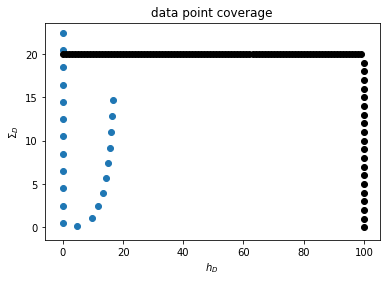

In [6]:
border_x = 100
border_y = 20

plt.scatter(interpy, interpx)
plt.scatter(np.array([border_x for k in range(border_y)]),np.array([k for k in range(border_y)]),color='black')
plt.scatter(np.array([k for k in range(border_x)]),np.array([border_y for k in range(border_x)]),color='black')
plt.title('data point coverage'); plt.ylabel('$\Sigma_D$'); plt.xlabel('$h_D$');
plt.show()

spacex, spacey = np.mgrid[0:20:42j,0:100:25j]

f_likely = interp.griddata(np.array(interpxy), np.array(interpz), (spacex,spacey), method='nearest')

In [ ]:
#cl_contour = [2.71]
cl_contour = [3.84]

outputx = spacex[:,0]
outputy = spacey[0,:]
outputz = np.array([])
opt_y_coord = np.array([])

for j, y in enumerate(outputy):
   peak_f = np.amin( f_likely[:,j] )
   opt_y_coord = np.append(opt_y_coord, peak_f)

plot_z = np.empty_like(f_likely)

for i, x in enumerate(outputx):
   for j, y in enumerate(outputy):
      plot_z[i,j] = 2.*(f_likely[i,j] - opt_y_coord[j])

spacex = np.transpose(spacex)
spacey = np.transpose(spacey)
plot_z = np.transpose(plot_z)
plt.pcolor(spacey, spacex, plot_z, cmap='Blues', vmin=plot_z.min(), vmax=plot_z.max())
plt.colorbar()
plt.contour(spacey, spacex, plot_z, cl_contour)
plt.xlabel('$h_D$'); plt.ylabel('$\Sigma_D$'); plt.title('Exclusion Contour')
plt.show()
plt.savefig("/Users/john/Documents/"+star_Cat+"_stars.jpg")

## Emcee

In [ ]:
epsilon = 0.0001

initial_guess = np.array([sig_star, sunZ, rhoDHalo])
initial_guess = np.append(initial_guess, sigma)
initial_guess = np.append(initial_guess, rho)

ndim, nwalkers = 27, 70
pos = [initial_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = mc.EnsembleSampler(nwalkers, ndim, lh.loglikelihood_emcee, args=(h_DD, sig_DD, zdata, mean_param, err_param))
%time sampler.run_mcmc(pos, 120)
result = sampler.chain[:, 50:, :].reshape((-1, ndim))

result_exp = result
result_exp[:, 2] = np.exp(result[:, 2])
baryon_return = map(lambda v: (v[0]), zip(*np.percentile(result_exp, [50], axis=0)))
hdd_ret, Sigdd_ret, llh_rett = lh.diskParamLlhReturn(baryon_return, h_DD, sig_DD, zdata, mean_param, err_param)

baryon_error = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(result_exp, [16, 50, 84], axis=0)))

print("Likelihood: " + str(llh_rett) )
print("return disk parameters: " + str(hdd_ret) + ", " + str(Sigdd_ret))
print("return baryon parameters: " + str(baryon_return))
print("parameter uncertainties: " + str(baryon_error))

In [ ]:
interpz_mc = []
interpy_mc = []
interpx_mc = []
interpxy_mc = []

ndim, nwalkers = 27, 100
pos = [initial_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

HD_step = 40
SgmD_step = 2
for nHD in tqdm(range(1,1000,HD_step)):
   for nSgmD in range(1,25,SgmD_step):
      h_DD = (nHD-0.8)/2
      sig_DD = (nSgmD-0.5)
      sampler = mc.EnsembleSampler(nwalkers, ndim, lh.loglikelihood, args=(h_DD, sig_DD, zdata, mean_param, err_param))
      sampler.run_mcmc(pos, 500)
      result = sampler.chain[:, 50:, :].reshape((-1, ndim))
      best_fit_param = result[:, 2]
      best_fit_param = np.exp(samples[:, 2])
      baryon_return = map(lambda v: (v[0]), zip(*np.percentile(best_fit_param, [50], axis=0)))
      hdd_ret, Sigdd_ret, llh_rett = lh.diskParamLlhReturn(baryon_return, h_DD, sig_DD, zdata, mean_param, err_param)
      interpx_mc.append( Sigdd_ret )
      interpy_mc.append( hdd_ret )
      interpxy_mc.append( [Sigdd_ret, hdd_ret] )
      interpz_mc.append( llh_rett )